In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the data
file_path = 'data/HSall_members.csv'
df = pd.read_csv(file_path)

# Filter for the 118th Congress
df_118th = df[df['congress'] == 118]

# Basic data cleaning
# Handle missing values if necessary
df_118th = df_118th.dropna(subset=['nominate_dim1', 'nominate_dim2'])  # Assuming ideological scores are crucial

# Convert data types if necessary
df_118th['born'] = pd.to_numeric(df_118th['born'], errors='coerce')
df_118th['died'] = pd.to_numeric(df_118th['died'], errors='coerce')

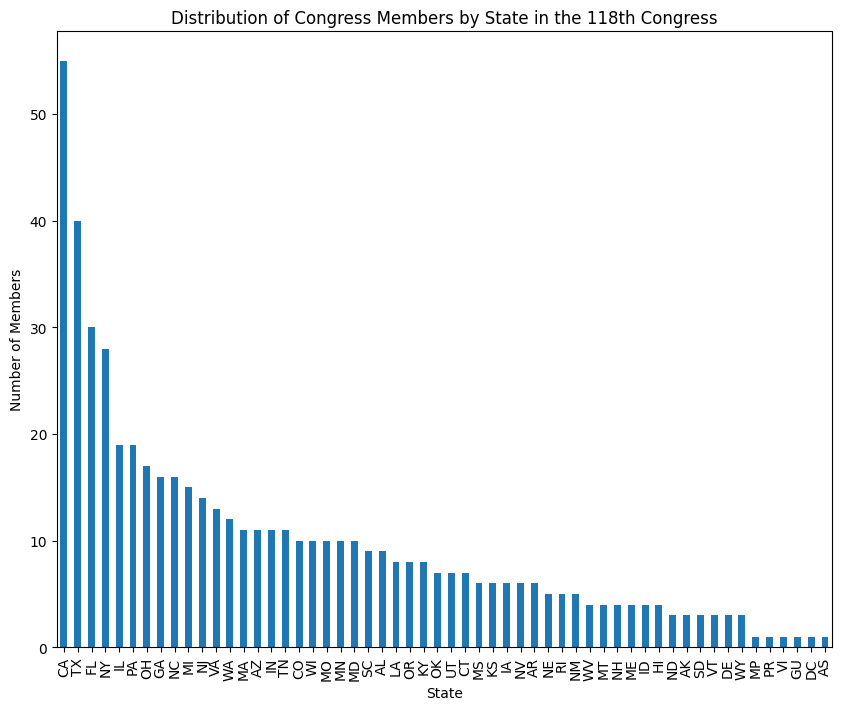

In [21]:
# Biographical Data Exploration
# Distribution of members by state
state_dist = df_118th['state_abbrev'].value_counts()
plt.figure(figsize=(10, 8))
state_dist.plot(kind='bar')
plt.title('Distribution of Congress Members by State in the 118th Congress')
plt.xlabel('State')
plt.ylabel('Number of Members')
plt.show()

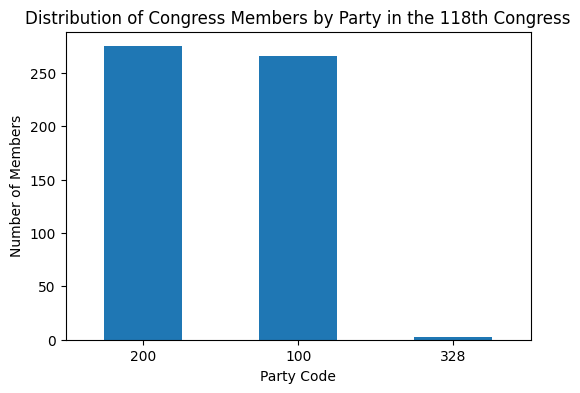

In [22]:
# Distribution of members by party
party_dist = df_118th['party_code'].value_counts()
plt.figure(figsize=(6, 4))
party_dist.plot(kind='bar')
plt.title('Distribution of Congress Members by Party in the 118th Congress')
plt.xlabel('Party Code')
plt.ylabel('Number of Members')
plt.xticks(rotation=0)
plt.show()

In [23]:
# Ideological Data Exploration
# Descriptive statistics of NOMINATE scores
print("Descriptive Statistics of NOMINATE Scores:")
print(df_118th[['nominate_dim1', 'nominate_dim2']].describe())

Descriptive Statistics of NOMINATE Scores:
       nominate_dim1  nominate_dim2
count     544.000000     544.000000
mean        0.072482       0.006601
std         0.469457       0.321982
min        -0.794000      -0.969000
25%        -0.375250      -0.199250
50%         0.172000       0.012000
75%         0.513250       0.232250
max         0.957000       0.957000


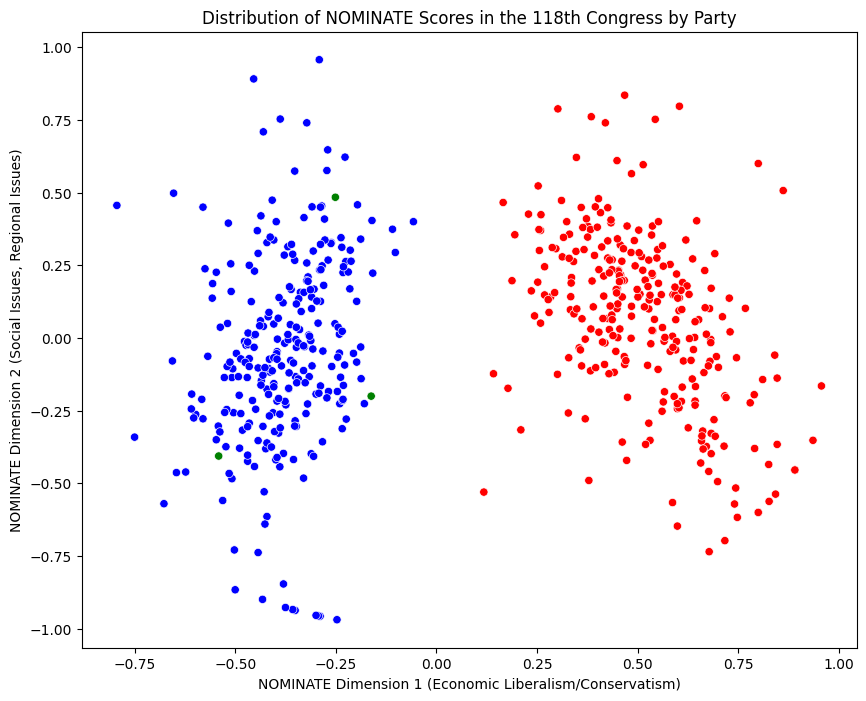

In [24]:
df_118th['party_color'] = df_118th['party_code'].map({200: 'red', 100: 'blue', 328: 'green'})

# Plotting
plt.figure(figsize=(10, 8))
# Scatter plot for members, colored by party affiliation
sns.scatterplot(data=df_118th, x='nominate_dim1', y='nominate_dim2', hue='party_color', palette={'red': 'red', 'blue': 'blue', 'green': 'green'}, legend=False)

# Add labels and title with descriptions for axes
plt.title('Distribution of NOMINATE Scores in the 118th Congress by Party')
plt.xlabel('NOMINATE Dimension 1 (Economic Liberalism/Conservatism)')
plt.ylabel('NOMINATE Dimension 2 (Social Issues, Regional Issues)')

plt.show()


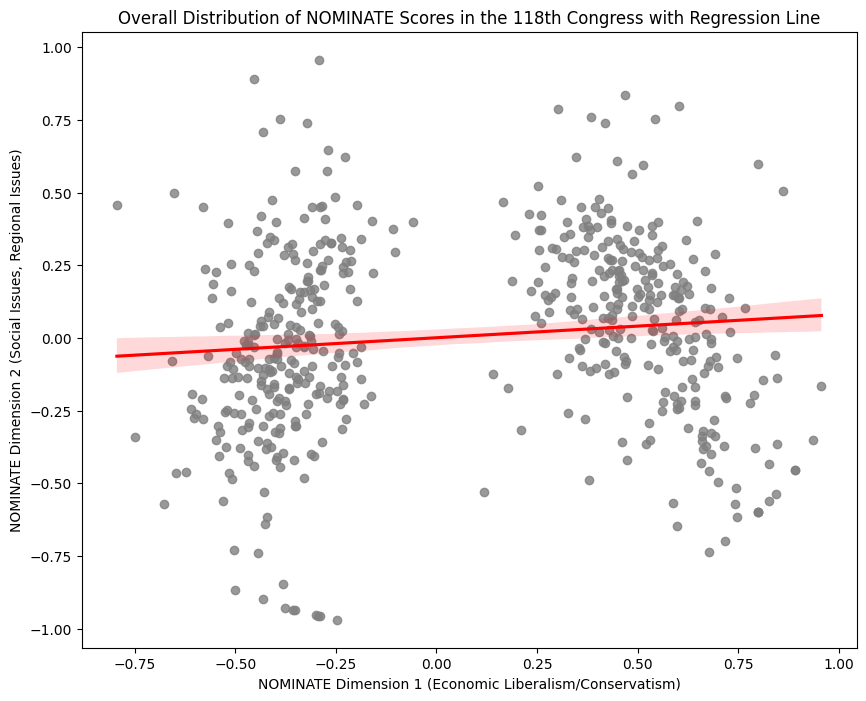

In [25]:
# Generate a scatter plot with a regression line for all members
plt.figure(figsize=(10, 8))
sns.regplot(data=df_118th, x='nominate_dim1', y='nominate_dim2', scatter_kws={'color': 'gray'}, line_kws={'color': 'red'})

# Add labels and title with descriptions for axes
plt.title('Overall Distribution of NOMINATE Scores in the 118th Congress with Regression Line')
plt.xlabel('NOMINATE Dimension 1 (Economic Liberalism/Conservatism)')
plt.ylabel('NOMINATE Dimension 2 (Social Issues, Regional Issues)')

plt.show()

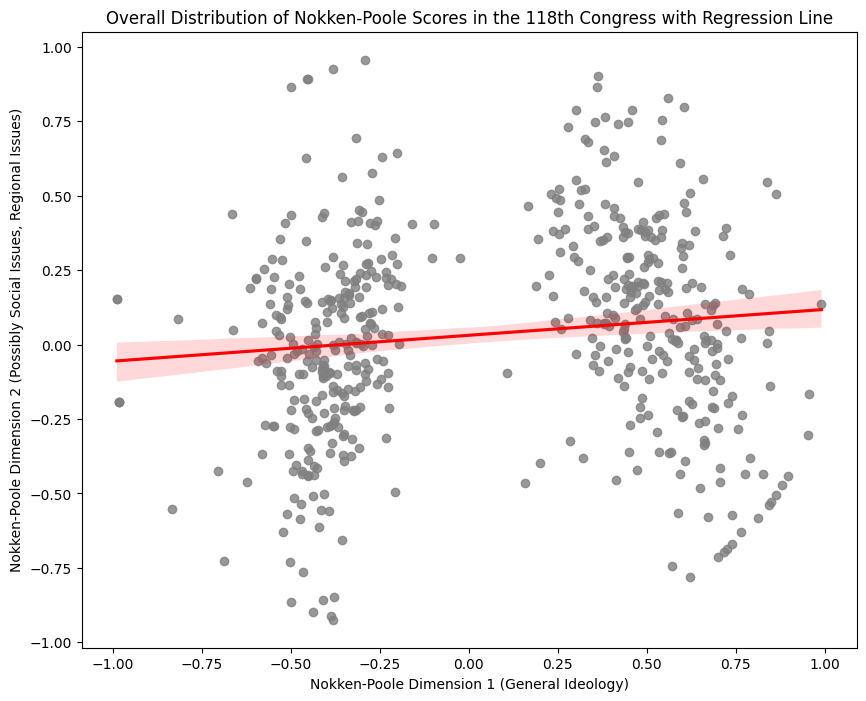

In [27]:
# Generate a scatter plot with a regression line for all members using Nokken-Poole dimensions
plt.figure(figsize=(10, 8))
sns.regplot(data=df_118th, x='nokken_poole_dim1', y='nokken_poole_dim2', scatter_kws={'color': 'gray'}, line_kws={'color': 'red'})

# Add labels and title with descriptions for axes
plt.title('Overall Distribution of Nokken-Poole Scores in the 118th Congress with Regression Line')
plt.xlabel('Nokken-Poole Dimension 1 (General Ideology)')
plt.ylabel('Nokken-Poole Dimension 2 (Possibly Social Issues, Regional Issues)')

plt.show()

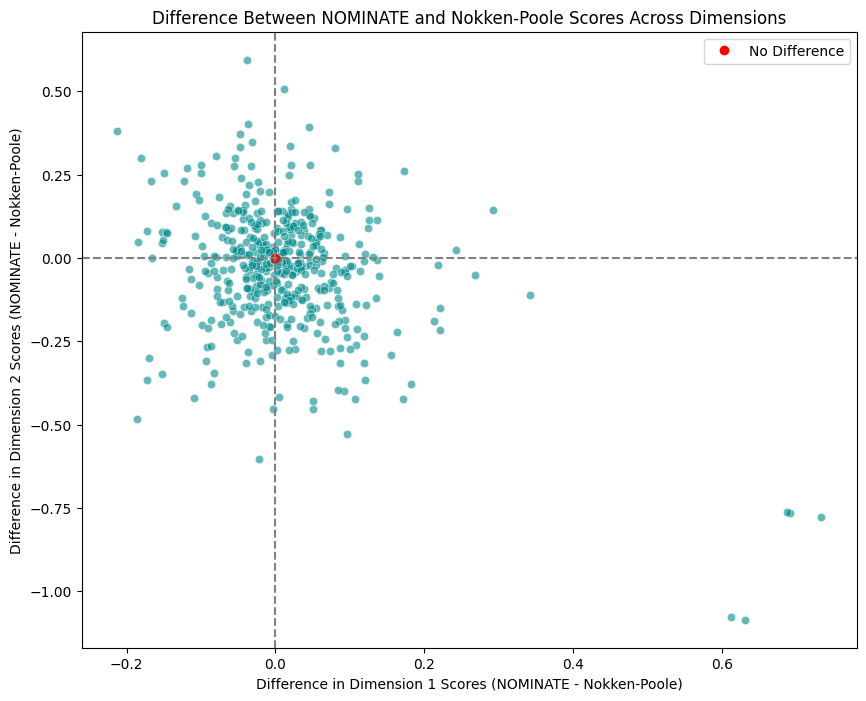

In [28]:
# Statistical summaries
print("Statistical Summary for Differences in Dimension 1:")
print(df_118th['dim1_diff'].describe())

print("\nStatistical Summary for Differences in Dimension 2:")
print(df_118th['dim2_diff'].describe())

# Histograms to visualize the distribution of differences
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_118th['dim1_diff'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Differences in Dimension 1')
plt.xlabel('Difference (NOMINATE - Nokken-Poole)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_118th['dim2_diff'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Differences in Dimension 2')
plt.xlabel('Difference (NOMINATE - Nokken-Poole)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot to visualize the relationship between differences in Dimension 1 and 2
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_118th, x='dim1_diff', y='dim2_diff', alpha=0.6)
plt.title('Differences in NOMINATE vs. Nokken-Poole Scores')
plt.xlabel('Difference in Dimension 1 Scores')
plt.ylabel('Difference in Dimension 2 Scores')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.show()

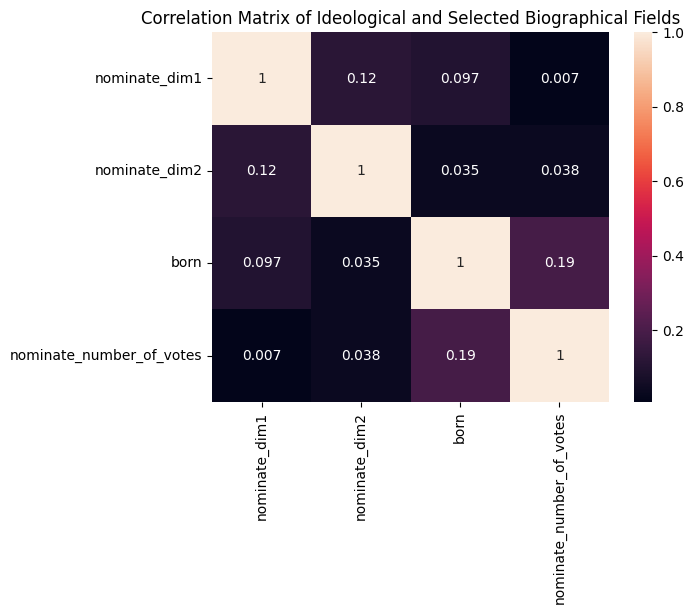

In [26]:
# Correlations
correlation_matrix = df_118th[['nominate_dim1', 'nominate_dim2', 'born', 'nominate_number_of_votes']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Ideological and Selected Biographical Fields')
plt.show()